In [2]:
import sys
sys.path.insert(0, "..//..//Router//")
sys.path.insert(0, "..//..//Router//Delivery-Clustering//")
sys.path.insert(0, "..//..//Router//Delivery-Router//")
sys.path.insert(0, "..//..//Router//GeneticAlgorithm//")
sys.path.insert(0, "..//..//Router//SalesforceAPI//")

import ClusteringOrders as cl
import DeliveryRouter as dr
import Matching as mt

import GeneticAlgorithm as ge
import SalesforceAPI as sf

from app import body_contructor

import folium
import branca.colormap as cm
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
seed = 21

In [4]:
def plot_map(df, column_cluster="cluster", icons_cluster_colors=False, deliverymen=True, zoom_start=7):
    
    colors = ['blue','red','green','orange','pink','black','lightblue','purple','gray','cadetblue']
    
    cmap = cm.LinearColormap(colors=colors,
                             vmin=np.min(df[column_cluster]),
                             vmax=np.max(df[column_cluster]),
                             caption = 'Cluster Labels'
                            )

    center = [np.mean([np.mean(df.DeliveryPoint__Latitude__s), np.mean(df.CollectPoint__Latitude__s),]),
              np.mean([np.mean(df.DeliveryPoint__Longitude__s), np.mean(df.CollectPoint__Longitude__s),]),
             ]
    
    map_sp = folium.Map(location=center, zoom_start=zoom_start, width='100%', height="100%")

    for index, d in df.iterrows():
        
        location_origem = [d['CollectPoint__Latitude__s'], d['CollectPoint__Longitude__s']]
        location_destino = [d['DeliveryPoint__Latitude__s'], d['DeliveryPoint__Longitude__s']]
        location_deliveryman = [d['DeliveryManLocation__Latitude__s'], d['DeliveryManLocation__Longitude__s']]

        folium.Marker(location_origem,
                      popup='origem',
                      icon=folium.Icon(color=colors[d[column_cluster]] if icons_cluster_colors else 'green'),
                     ).add_to(map_sp)

        folium.Marker(location_destino,
                      popup='destino',
                      icon=folium.Icon(color=colors[d[column_cluster]] if icons_cluster_colors else 'blue'),
                     ).add_to(map_sp)

        folium.PolyLine([location_origem, location_destino],
                        weight=2.5,
                        color=cmap(d[column_cluster]),
                       ).add_to(map_sp)
        
        if deliverymen:
            folium.Marker(location_deliveryman,
                          popup=f'Delivery Man: {d["id_deliveryman"]}',
                          icon=folium.Icon("red"),
                         ).add_to(map_sp)

    if deliverymen:
        legend_html =   f'''
                        <div style="position: fixed; 
                                    bottom: 50px; right: 50px; width: 150px; height: 115px;
                                    border:2px solid grey; z-index:9999; font-size:14px;
                                    ">&nbsp; Legend <br>
                                      &nbsp; Origin &nbsp; <i class="fa fa-map-marker fa-2x" style="color:green"></i><br>
                                      &nbsp; Destination &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i><br>
                                      &nbsp; Deliveryman &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i>
                        </div>
                        '''
    else:
        legend_html =   f'''
                        <div style="position: fixed; 
                                    bottom: 50px; right: 50px; width: 150px; height: 90px; 
                                    border:2px solid grey; z-index:9999; font-size:14px;
                                    ">&nbsp; Legend <br>
                                      &nbsp; Origin &nbsp; <i class="fa fa-map-marker fa-2x" style="color:green"></i><br>
                                      &nbsp; Destination &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i>
                        </div>
                        '''

    map_sp.get_root().html.add_child(folium.Element(legend_html))

    map_sp.add_child(cmap)
    
    display(map_sp)

# Bases

In [5]:
deliverymen = pd.read_csv('.\\Bases\\Entregadores__c_2.csv')
deliverymen

,Id,car_capacity__c,DeliveryManLocation__Latitude__s,DeliveryManLocation__Longitude__s
0,a005Y00002GIPcQQAX,Média,-24.006472,-46.272175
1,a005Y00002GIPcRQAX,Média,-23.115526,-46.552918
2,a005Y00002GIPcSQAX,Média,-23.407401,-46.758610
3,a005Y00002GIPcTQAX,Alta,-23.415004,-46.897116
4,a005Y00002GIPcUQAX,Alta,-23.630328,-46.640746
5,a005Y00002GIPcVQAX,Baixa,-23.595924,-46.669864
6,a005Y00002GIPcWQAX,Alta,-23.554467,-46.308525
7,a005Y00002GIPcXQAX,Alta,-23.666131,-46.413293
8,a005Y00002GIPcYQAX,Média,-23.597327,-46.595990
9,a005Y00002GIPcZQAX,Baixa,-23.973751,-46.371917


In [6]:
orders = pd.read_csv('.\\Bases\\SolicitacaoEntrega__c.csv')
orders = orders.drop("CreatedDate", 1)

# como amostragem foi selecionado 100 entregas aleatóriamente
orders = orders.sample(n=100, random_state=seed)
orders = orders.reset_index().drop("index", 1)
orders

,Id,TamanhoPacote__c,CollectPoint__Latitude__s,CollectPoint__Longitude__s,DeliveryPoint__Latitude__s,DeliveryPoint__Longitude__s
0,317bc187384c65775ea8f3b23aad4acf,Baixa,-22.556606,-47.442603,-23.665931,-47.029936
1,47999a7490ff2905f7ca3da2edcc9c52,Baixa,-23.690136,-46.704876,-23.448542,-46.597961
2,db8f21db0519c6ab351e3bbf641439ca,Baixa,-23.500717,-46.589716,-22.869819,-48.456964
3,8f815207602f16cdf25a3fb1858ca6be,Baixa,-23.304322,-45.977171,-23.854365,-46.954536
4,eaae3cf15cb2de079d33c44d3a8b2dc9,Baixa,-23.736102,-46.441666,-23.582304,-46.403328
...,...,...,...,...,...,...
95,04da4dc0ed95cc93f9f25375fa08ad47,Baixa,-21.366381,-48.220367,-23.692408,-46.671153
96,a7fdfd7d7ae7a53a8232d6d0d7db215b,Alta,-23.489888,-46.372657,-23.496791,-46.555893
97,13917780488fcc5fa2f9fa3c45549c80,Baixa,-23.494074,-46.447659,-23.551135,-46.351516
98,7b8c347893b1c057c2eb9d8d22435e6e,Baixa,-23.470853,-46.647959,-23.484928,-46.378511


# Funções auxiliares

In [7]:
def calculateCartesianDistance(lat_a, long_a, lat_b, long_b):
    distance = np.sqrt(((lat_a - lat_b) ** 2) + ((long_a - long_b) ** 2))
    return distance

def calculateRouteDistances(df_matching):
    routes = list()
    for deliveryman in deliverymen.iterrows():
        id_deliveryman = deliveryman[1]["Id"]
        total_distance = 0

        df_orders_aux = (
            df_matching
            .query(f"id_deliveryman == '{id_deliveryman}'")
            .reset_index()
            .drop("index", 1)
        )
        
        first_order = df_orders_aux.iloc[:1]
        id_last_order = df_orders_aux.iloc[-1:]["Id"].values[0]

        total_distance = calculateCartesianDistance(
            lat_a=deliveryman[1]["DeliveryManLocation__Latitude__s"],
            long_a=deliveryman[1]["DeliveryManLocation__Longitude__s"],
            lat_b=first_order["CollectPoint__Latitude__s"].values[0],
            long_b=first_order["CollectPoint__Longitude__s"].values[0],
        )

        for order in df_orders_aux.iterrows():
            order_distance = calculateCartesianDistance(
                lat_a=order[1]["CollectPoint__Latitude__s"],
                long_a=order[1]["CollectPoint__Longitude__s"],
                lat_b=order[1]["DeliveryPoint__Latitude__s"],
                long_b=order[1]["DeliveryPoint__Longitude__s"],
            )

            total_distance += order_distance
            
            if order[1]["Id"] != id_last_order:
                next_point = df_orders_aux.iloc[order[0]+1]

                distance_next_point = calculateCartesianDistance(
                    lat_a=order[1]["DeliveryPoint__Latitude__s"],
                    long_a=order[1]["DeliveryPoint__Longitude__s"],
                    lat_b=next_point["CollectPoint__Latitude__s"],
                    long_b=next_point["CollectPoint__Longitude__s"],
                )
            # distancia de volta à origem do deliveryman
            else:
                next_point = deliveryman

                distance_next_point = calculateCartesianDistance(
                    lat_a=order[1]["DeliveryPoint__Latitude__s"],
                    long_a=order[1]["DeliveryPoint__Longitude__s"],
                    lat_b=deliveryman[1]["DeliveryManLocation__Latitude__s"],
                    long_b=deliveryman[1]["DeliveryManLocation__Longitude__s"],
                )

            total_distance += distance_next_point

        routes.append({"id_deliveryman":id_deliveryman,
                       "total_distance":total_distance})
        
    return routes

# Teste 1
### Distância percorrida sem Clusterização e sem Roteirização por Algoritmo Genético

Considerando um cenário em que não há nenhuma tentativa de otimização algotítimica da rota, as entregas seriam entregues para cada entregado por ordem de cadastro.

Nesse caso, para o cáculo da distância percorrida será considerado como sequência o índice das bases, ou seja, o primeiro entregador receberá as 10 primeiras entregas da base, o segundo entregador as 10 sequintes e assim sucessivamente.

### Distribuindo 1 entregador para cada 10 entregas da base

In [18]:
df_matching = orders.copy()

# Para a análise o tamnho dos pacotes e a capacidade dos carros são irrelevantes
df_matching = df_matching.drop(["TamanhoPacote__c"], 1)

list_df = list()
for row in deliverymen.iterrows():
    aux = df_matching.iloc[row[0]*10:row[0]*10+10]
    aux["id_deliveryman"] = row[1]["Id"]
    aux["cluster"] = row[0]
    aux["DeliveryManLocation__Latitude__s"] = row[1]["DeliveryManLocation__Latitude__s"]
    aux["DeliveryManLocation__Longitude__s"] = row[1]["DeliveryManLocation__Longitude__s"]
    list_df.append(aux)

df_matching = pd.concat(list_df)
df_matching

,Id,CollectPoint__Latitude__s,CollectPoint__Longitude__s,DeliveryPoint__Latitude__s,DeliveryPoint__Longitude__s,id_deliveryman,cluster,DeliveryManLocation__Latitude__s,DeliveryManLocation__Longitude__s
0,317bc187384c65775ea8f3b23aad4acf,-22.556606,-47.442603,-23.665931,-47.029936,a005Y00002GIPcQQAX,0,-24.006472,-46.272175
1,47999a7490ff2905f7ca3da2edcc9c52,-23.690136,-46.704876,-23.448542,-46.597961,a005Y00002GIPcQQAX,0,-24.006472,-46.272175
2,db8f21db0519c6ab351e3bbf641439ca,-23.500717,-46.589716,-22.869819,-48.456964,a005Y00002GIPcQQAX,0,-24.006472,-46.272175
3,8f815207602f16cdf25a3fb1858ca6be,-23.304322,-45.977171,-23.854365,-46.954536,a005Y00002GIPcQQAX,0,-24.006472,-46.272175
4,eaae3cf15cb2de079d33c44d3a8b2dc9,-23.736102,-46.441666,-23.582304,-46.403328,a005Y00002GIPcQQAX,0,-24.006472,-46.272175
...,...,...,...,...,...,...,...,...,...
95,04da4dc0ed95cc93f9f25375fa08ad47,-21.366381,-48.220367,-23.692408,-46.671153,a005Y00002GIPcZQAX,9,-23.973751,-46.371917
96,a7fdfd7d7ae7a53a8232d6d0d7db215b,-23.489888,-46.372657,-23.496791,-46.555893,a005Y00002GIPcZQAX,9,-23.973751,-46.371917
97,13917780488fcc5fa2f9fa3c45549c80,-23.494074,-46.447659,-23.551135,-46.351516,a005Y00002GIPcZQAX,9,-23.973751,-46.371917
98,7b8c347893b1c057c2eb9d8d22435e6e,-23.470853,-46.647959,-23.484928,-46.378511,a005Y00002GIPcZQAX,9,-23.973751,-46.371917


### Calculando a distância percorrida por cada entregador

In [19]:
df_matching.groupby("id_deliveryman").agg(count=pd.NamedAgg("Id", "count"))

,count
id_deliveryman,
a005Y00002GIPcQQAX,10
a005Y00002GIPcRQAX,10
a005Y00002GIPcSQAX,10
a005Y00002GIPcTQAX,10
a005Y00002GIPcUQAX,10
a005Y00002GIPcVQAX,10
a005Y00002GIPcWQAX,10
a005Y00002GIPcXQAX,10
a005Y00002GIPcYQAX,10


In [20]:
result = calculateRouteDistances(df_matching)
df_result_1 = pd.DataFrame(result)
df_result_1

,id_deliveryman,total_distance
0,a005Y00002GIPcQQAX,20.780485
1,a005Y00002GIPcRQAX,20.531239
2,a005Y00002GIPcSQAX,19.788684
3,a005Y00002GIPcTQAX,22.788382
4,a005Y00002GIPcUQAX,36.764296
5,a005Y00002GIPcVQAX,18.562453
6,a005Y00002GIPcWQAX,21.266422
7,a005Y00002GIPcXQAX,30.299847
8,a005Y00002GIPcYQAX,31.670557
9,a005Y00002GIPcZQAX,22.307358


In [21]:
for i in range(10):
    plot_map(df_matching.query(f"cluster == {i}"))

# Teste 2
### Distância percorrida com Clusterização e Matching, porém sem Roteirização por Algoritmo Genético

Neste caso, é utilizado uma Clusterização das entregas com KMeans, onde o número de clusters é o número de entregadores (no caso 10).

O Matching entre cada cluster de entregas e um entregador, será a menor distância entre a localização do entregador e a localização de uma coleta. 

Nesse caso, para o cáculo da distância percorrida será considerado como sequência o índice da base `orders` sem nenhuma otimização da sequencia dos pontos.

In [22]:
print("\nClustering orders with KMeans...")
order_clusters = cl.run(deliverymen=deliverymen.copy(), orders=orders.copy(), seed=seed)

print("\nMatching orders and deliverymen...")
df_matching = mt.run(order_clusters.copy(), deliverymen.copy())

df_matching


Clustering orders with KMeans...
Defined 10 clusters

Matching orders and deliverymen...


,Id,TamanhoPacote__c,CollectPoint__Latitude__s,CollectPoint__Longitude__s,DeliveryPoint__Latitude__s,DeliveryPoint__Longitude__s,cluster,id_deliveryman,car_capacity__c,DeliveryManLocation__Latitude__s,DeliveryManLocation__Longitude__s
0,317bc187384c65775ea8f3b23aad4acf,Baixa,-22.556606,-47.442603,-23.665931,-47.029936,6,a005Y00002GIPcRQAX,Média,-23.115526,-46.552918
1,47999a7490ff2905f7ca3da2edcc9c52,Baixa,-23.690136,-46.704876,-23.448542,-46.597961,2,a005Y00002GIPcYQAX,Média,-23.597327,-46.595990
2,db8f21db0519c6ab351e3bbf641439ca,Baixa,-23.500717,-46.589716,-22.869819,-48.456964,7,a005Y00002GIPcXQAX,Alta,-23.666131,-46.413293
3,8f815207602f16cdf25a3fb1858ca6be,Baixa,-23.304322,-45.977171,-23.854365,-46.954536,2,a005Y00002GIPcYQAX,Média,-23.597327,-46.595990
4,eaae3cf15cb2de079d33c44d3a8b2dc9,Baixa,-23.736102,-46.441666,-23.582304,-46.403328,2,a005Y00002GIPcYQAX,Média,-23.597327,-46.595990
...,...,...,...,...,...,...,...,...,...,...,...
95,04da4dc0ed95cc93f9f25375fa08ad47,Baixa,-21.366381,-48.220367,-23.692408,-46.671153,9,a005Y00002GIPcQQAX,Média,-24.006472,-46.272175
96,a7fdfd7d7ae7a53a8232d6d0d7db215b,Alta,-23.489888,-46.372657,-23.496791,-46.555893,4,a005Y00002GIPcUQAX,Alta,-23.630328,-46.640746
97,13917780488fcc5fa2f9fa3c45549c80,Baixa,-23.494074,-46.447659,-23.551135,-46.351516,2,a005Y00002GIPcYQAX,Média,-23.597327,-46.595990
98,7b8c347893b1c057c2eb9d8d22435e6e,Baixa,-23.470853,-46.647959,-23.484928,-46.378511,2,a005Y00002GIPcYQAX,Média,-23.597327,-46.595990


In [23]:
df_matching.groupby("id_deliveryman").agg(count=pd.NamedAgg("Id", "count"))

,count
id_deliveryman,
a005Y00002GIPcQQAX,7
a005Y00002GIPcRQAX,16
a005Y00002GIPcSQAX,4
a005Y00002GIPcTQAX,5
a005Y00002GIPcUQAX,8
a005Y00002GIPcVQAX,4
a005Y00002GIPcWQAX,3
a005Y00002GIPcXQAX,9
a005Y00002GIPcYQAX,42


In [24]:
result = calculateRouteDistances(df_matching)
df_result_2 = pd.DataFrame(result)
df_result_2

,id_deliveryman,total_distance
0,a005Y00002GIPcQQAX,40.926175
1,a005Y00002GIPcRQAX,31.204523
2,a005Y00002GIPcSQAX,17.534465
3,a005Y00002GIPcTQAX,42.591709
4,a005Y00002GIPcUQAX,5.952045
5,a005Y00002GIPcVQAX,31.248307
6,a005Y00002GIPcWQAX,6.682351
7,a005Y00002GIPcXQAX,38.214004
8,a005Y00002GIPcYQAX,29.015330
9,a005Y00002GIPcZQAX,10.992736


In [25]:
for i in range(10):
    plot_map(df_matching.query(f"cluster == {i}"))

# Teste 3
### Distância percorrida com Clusterização e com Roteirização por Algoritmo Genético

In [26]:
print("\nClustering orders with KMeans...")
order_clusters = cl.run(deliverymen=deliverymen.copy(), orders=orders.copy(), seed=seed)

print("\nMatching orders and deliverymen...")
df_matching = mt.run(order_clusters.copy(), deliverymen.copy())


Clustering orders with KMeans...
Defined 10 clusters

Matching orders and deliverymen...


In [27]:
print("\nStarting Router using Genetic Algorithm...")
result = dr.run(df_matching)


Starting Router using Genetic Algorithm...

running to cluster 0...
Melhor solução -> G: 73 - Distância percorrida: 5.961694230431869 - Cromossomo: [4, 2, 5, 7, 0, 6, 3, 1, 8]
check_chromosome: True

running to cluster 1...
Melhor solução -> G: 1 - Distância percorrida: 3.5264495145426213 - Cromossomo: [6, 4, 2, 0, 5, 1, 3]
check_chromosome: True

running to cluster 2...
Melhor solução -> G: 414 - Distância percorrida: 23.333906375713354 - Cromossomo: [42, 40, 36, 20, 37, 77, 24, 45, 18, 69, 34, 47, 53, 71, 41, 32, 33, 79, 22, 65, 35, 26, 2, 72, 51, 54, 12, 27, 16, 55, 73, 63, 14, 59, 30, 83, 61, 17, 10, 60, 13, 81, 15, 4, 8, 75, 38, 46, 21, 0, 57, 78, 9, 25, 39, 76, 84, 66, 31, 3, 43, 11, 62, 82, 49, 48, 80, 58, 44, 5, 23, 70, 67, 28, 6, 7, 74, 1, 56, 64, 29, 19, 68, 52, 50]
check_chromosome: True

running to cluster 3...
Melhor solução -> G: 7 - Distância percorrida: 9.561940085303291 - Cromossomo: [8, 6, 0, 4, 2, 5, 7, 3, 1]
check_chromosome: True

running to cluster 4...
Melhor so

In [28]:
df_result_3 = pd.DataFrame(result)
df_result_3 = df_result_3.reset_index()
df_result_3 = df_result_3.rename(columns={"index":"cluster", "travelled_distance":"total_distance"})
df_result_3 = df_result_3.join(df_matching[["cluster", "id_deliveryman"]].drop_duplicates().set_index("cluster"), on="cluster")
df_result_3 = df_result_3[["id_deliveryman", "total_distance"]]

df_result_3

,id_deliveryman,total_distance
0,a005Y00002GIPcSQAX,5.961694
1,a005Y00002GIPcWQAX,3.526450
2,a005Y00002GIPcYQAX,23.333906
3,a005Y00002GIPcVQAX,9.561940
4,a005Y00002GIPcUQAX,3.809947
5,a005Y00002GIPcTQAX,14.526571
6,a005Y00002GIPcRQAX,14.553939
7,a005Y00002GIPcXQAX,13.048276
8,a005Y00002GIPcZQAX,8.905542
9,a005Y00002GIPcQQAX,9.644076


In [29]:
for i in range(10):
    plot_map(df_matching.query(f"cluster == {i}"))

In [30]:
df_result_1 = df_result_1.rename(columns={"total_distance":"total_distance_test_1"})
df_result_2 = df_result_2.rename(columns={"total_distance":"total_distance_test_2"})
df_result_3 = df_result_3.rename(columns={"total_distance":"total_distance_test_3"})

df_result = (
    df_result_1
    .join(df_result_2.set_index("id_deliveryman"), on="id_deliveryman")
    .join(df_result_3.set_index("id_deliveryman"), on="id_deliveryman")
)

df_result["diff_1_2_%"] = (((df_result["total_distance_test_2"] - df_result["total_distance_test_1"]) / df_result["total_distance_test_1"]) * 100)
df_result["diff_2_3_%"] = (((df_result["total_distance_test_3"] - df_result["total_distance_test_2"]) / df_result["total_distance_test_2"]) * 100)
df_result["diff_1_3_%"] = (((df_result["total_distance_test_3"] - df_result["total_distance_test_1"]) / df_result["total_distance_test_1"]) * 100)

df_result

,id_deliveryman,total_distance_test_1,total_distance_test_2,total_distance_test_3,diff_1_2_%,diff_2_3_%,diff_1_3_%
0,a005Y00002GIPcQQAX,20.780485,40.926175,9.644076,96.945235,-76.435433,-53.590707
1,a005Y00002GIPcRQAX,20.531239,31.204523,14.553939,51.985581,-53.359520,-29.113196
2,a005Y00002GIPcSQAX,19.788684,17.534465,5.961694,-11.391454,-66.000136,-69.873215
3,a005Y00002GIPcTQAX,22.788382,42.591709,14.526571,86.900983,-65.893429,-36.254485
4,a005Y00002GIPcUQAX,36.764296,5.952045,3.809947,-83.810257,-35.989276,-89.636828
5,a005Y00002GIPcVQAX,18.562453,31.248307,9.561940,68.341478,-69.400134,-48.487734
6,a005Y00002GIPcWQAX,21.266422,6.682351,3.526450,-68.577923,-47.227416,-83.417758
7,a005Y00002GIPcXQAX,30.299847,38.214004,13.048276,26.119464,-65.854727,-56.936165
8,a005Y00002GIPcYQAX,31.670557,29.015330,23.333906,-8.383900,-19.580764,-26.323032
9,a005Y00002GIPcZQAX,22.307358,10.992736,8.905542,-50.721478,-18.987031,-60.078006


In [32]:
df_result_1.agg(
    avg=pd.NamedAgg("total_distance_test_1", "mean"),
    std=pd.NamedAgg("total_distance_test_1", "std")
)

,total_distance_test_1
avg,24.475972
std,6.152619


In [33]:
df_result_2.agg(
    avg=pd.NamedAgg("total_distance_test_2", "mean"),
    std=pd.NamedAgg("total_distance_test_2", "std")
)

,total_distance_test_2
avg,25.436165
std,14.062470


In [34]:
df_result_3.agg(
    avg=pd.NamedAgg("total_distance_test_3", "mean"),
    std=pd.NamedAgg("total_distance_test_3", "std")
)

,total_distance_test_3
avg,10.687234
std,5.978092


In [35]:
qtd_orders = df_matching.groupby("id_deliveryman").agg(count=pd.NamedAgg("Id", "count")).reset_index().set_index("id_deliveryman")

In [36]:
df_result_2 = df_result.join(qtd_orders, "id_deliveryman")

In [37]:
df_result_2["total_distance_test_1_mean"] = df_result_2["total_distance_test_1"]/10
df_result_2["total_distance_test_2_mean"] = df_result_2["total_distance_test_2"]/df_result_2["count"]
df_result_2["total_distance_test_3_mean"] = df_result_2["total_distance_test_3"]/df_result_2["count"]

In [38]:
df_result_2

,id_deliveryman,total_distance_test_1,total_distance_test_2,total_distance_test_3,diff_1_2_%,diff_2_3_%,diff_1_3_%,count,total_distance_test_1_mean,total_distance_test_2_mean,total_distance_test_3_mean
0,a005Y00002GIPcQQAX,20.780485,40.926175,9.644076,96.945235,-76.435433,-53.590707,7,2.078049,5.846596,1.377725
1,a005Y00002GIPcRQAX,20.531239,31.204523,14.553939,51.985581,-53.359520,-29.113196,16,2.053124,1.950283,0.909621
2,a005Y00002GIPcSQAX,19.788684,17.534465,5.961694,-11.391454,-66.000136,-69.873215,4,1.978868,4.383616,1.490424
3,a005Y00002GIPcTQAX,22.788382,42.591709,14.526571,86.900983,-65.893429,-36.254485,5,2.278838,8.518342,2.905314
4,a005Y00002GIPcUQAX,36.764296,5.952045,3.809947,-83.810257,-35.989276,-89.636828,8,3.676430,0.744006,0.476243
5,a005Y00002GIPcVQAX,18.562453,31.248307,9.561940,68.341478,-69.400134,-48.487734,4,1.856245,7.812077,2.390485
6,a005Y00002GIPcWQAX,21.266422,6.682351,3.526450,-68.577923,-47.227416,-83.417758,3,2.126642,2.227450,1.175483
7,a005Y00002GIPcXQAX,30.299847,38.214004,13.048276,26.119464,-65.854727,-56.936165,9,3.029985,4.246000,1.449808
8,a005Y00002GIPcYQAX,31.670557,29.015330,23.333906,-8.383900,-19.580764,-26.323032,42,3.167056,0.690841,0.555569
9,a005Y00002GIPcZQAX,22.307358,10.992736,8.905542,-50.721478,-18.987031,-60.078006,2,2.230736,5.496368,4.452771


In [41]:
print("mean distance test 1:", np.sum(df_result_2["total_distance_test_1"]) / 100)
print("mean distance test 2:", np.sum(df_result_2["total_distance_test_2"]) / np.sum(df_result_2["count"]))
print("mean distance test 3:", np.sum(df_result_2["total_distance_test_3"]) / np.sum(df_result_2["count"]))

mean distance test 1: 2.447597217304108
mean distance test 2: 2.543616460162833
mean distance test 3: 1.0687234194371158


In [39]:
df_result_2.to_csv(".\\Bases\\PoC_Algoritmo_Genetico_resultado.csv", index=False)

# Teste 4

Teste para coletar, para cada cluster, o tempo médio de processamento e o número médio de gerações necessárias para se chegar  no valor ótimo de cada rota.

- 10 iterações do algoritmo, seguindo o processo completo como no Teste 3.

In [17]:
print("\nClustering orders with KMeans...")
order_clusters = cl.run(deliverymen=deliverymen.copy(), orders=orders.copy(), seed=seed)

print("\nMatching orders and deliverymen...")
df_matching = mt.run(order_clusters.copy(), deliverymen.copy())


Clustering orders with KMeans...
Defined 10 clusters

Matching orders and deliverymen...


In [18]:
results = list()

for i in range(10):
    print(f"\n-------- Iteração {i} --------")
    result = dr.run(df_matching)
    results.append(result)


-------- Iteração 0 --------

running to cluster 0...
Melhor solução -> Generation: 459 - Distância percorrida: 5.961694230431869 - Cromossomo: [4, 2, 5, 7, 0, 6, 3, 1, 8]
check_chromosome: True
execution_time: 7.011900186538696

running to cluster 1...
Melhor solução -> Generation: 3 - Distância percorrida: 3.5264495145426213 - Cromossomo: [6, 4, 2, 0, 5, 1, 3]
check_chromosome: True
execution_time: 6.272822380065918

running to cluster 2...
Melhor solução -> Generation: 780 - Distância percorrida: 23.70416455574855 - Cromossomo: [42, 40, 75, 77, 4, 36, 14, 24, 45, 26, 27, 65, 32, 22, 2, 0, 78, 61, 20, 30, 63, 73, 57, 16, 17, 66, 33, 6, 55, 51, 41, 28, 3, 34, 74, 49, 67, 46, 68, 69, 62, 47, 52, 59, 43, 21, 12, 38, 37, 79, 8, 71, 10, 76, 5, 15, 81, 64, 1, 56, 50, 18, 39, 48, 44, 19, 83, 13, 29, 58, 82, 7, 35, 70, 31, 9, 11, 53, 72, 23, 80, 25, 54, 84, 60]
check_chromosome: True
execution_time: 252.91339135169983

running to cluster 3...
Melhor solução -> Generation: 0 - Distância perc

Melhor solução -> Generation: 157 - Distância percorrida: 9.561940085303291 - Cromossomo: [8, 6, 0, 4, 2, 5, 7, 3, 1]
check_chromosome: True
execution_time: 7.414360523223877

running to cluster 4...
Melhor solução -> Generation: 868 - Distância percorrida: 4.242295782493225 - Cromossomo: [16, 14, 8, 10, 2, 3, 15, 0, 12, 4, 9, 6, 13, 7, 11, 1, 5]
check_chromosome: True
execution_time: 12.103816509246826

running to cluster 5...
Melhor solução -> Generation: 14 - Distância percorrida: 14.838703314435612 - Cromossomo: [2, 0, 9, 7, 5, 3, 4, 6, 1, 10, 8]
check_chromosome: True
execution_time: 6.913946151733398

running to cluster 6...
Melhor solução -> Generation: 627 - Distância percorrida: 15.726550177208923 - Cromossomo: [8, 6, 2, 17, 29, 0, 4, 13, 31, 23, 25, 14, 11, 19, 9, 21, 32, 7, 27, 15, 1, 26, 18, 20, 28, 16, 24, 12, 22, 3, 5, 10, 30]
check_chromosome: True
execution_time: 25.079814195632935

running to cluster 7...
Melhor solução -> Generation: 869 - Distância percorrida: 13.543

Melhor solução -> Generation: 977 - Distância percorrida: 15.26008482490963 - Cromossomo: [8, 6, 17, 0, 13, 2, 11, 4, 9, 15, 16, 1, 12, 14, 5, 10, 3, 7, 18]
check_chromosome: True
execution_time: 11.960585594177246

running to cluster 8...
Melhor solução -> Generation: 21 - Distância percorrida: 8.90554195817513 - Cromossomo: [2, 0, 3, 4, 1]
check_chromosome: True
execution_time: 6.039337158203125

running to cluster 9...
Melhor solução -> Generation: 868 - Distância percorrida: 10.145537278455583 - Cromossomo: [12, 10, 6, 0, 13, 2, 4, 8, 3, 1, 14, 11, 9, 7, 5]
check_chromosome: True
execution_time: 9.101207494735718

-------- Iteração 7 --------

running to cluster 0...
Melhor solução -> Generation: 298 - Distância percorrida: 5.961694230431869 - Cromossomo: [4, 2, 5, 7, 0, 6, 3, 1, 8]
check_chromosome: True
execution_time: 6.470543146133423

running to cluster 1...
Melhor solução -> Generation: 103 - Distância percorrida: 3.5264495145426213 - Cromossomo: [6, 4, 2, 0, 5, 1, 3]
check_c

In [20]:
for i in range(10):
    df_teste_4 = pd.DataFrame(results[i])
    df_teste_4.to_csv(f".\\Bases\\PoC_Algoritmo_Genetico_resultado\\df_teste_4_iter_{str(i)}.csv", index=False)

In [164]:
results = list()

for i in range(10):
    df = pd.read_csv(f".\\Bases\\PoC_Algoritmo_Genetico_resultado\\df_teste_4_iter_{str(i)}.csv")
    
    df["nr_entregas"] = -1
    df = df.reset_index()

    for row in df.iterrows():
        i = row[0]
        points = row[1]["chromosome"].replace("[", "").replace("]", "").replace(" ", "").split(",")
        nr_orders = int(len(points) - 1) / 2
        df["nr_entregas"] = np.where(df["index"] == i, nr_orders, df["nr_entregas"])
    
    results.append(df)
    
df_result_teste_4 = pd.concat(results)

agg = (
    df_result_teste_4
    .groupby(["cluster", "nr_entregas"])
    .agg(
        nr_geracoes_media=pd.NamedAgg("generation", "mean"),
        nr_geracoes_min=pd.NamedAgg("generation", "min"),
        nr_geracoes_max=pd.NamedAgg("generation", "max"),
        tempo_medio_execucao=pd.NamedAgg("execution_time", "mean"),
    )
    .reset_index()
)

agg

,cluster,nr_entregas,nr_geracoes_media,nr_geracoes_min,nr_geracoes_max,tempo_medio_execucao
0,0,4.0,331.8,76,642,6.697523
1,1,3.0,40.7,3,109,6.283929
2,2,42.0,456.4,123,959,243.072637
3,3,4.0,298.9,0,834,6.861384
4,4,8.0,510.8,96,913,10.667396
5,5,5.0,405.0,14,934,7.465828
6,6,16.0,678.5,64,997,27.136923
7,7,9.0,664.6,61,977,11.726128
8,8,2.0,5.0,0,21,6.351947
9,9,7.0,502.1,267,868,9.378676


In [160]:
agg.to_csv(f".\\Bases\\PoC_Algoritmo_Genetico_resultado\\df_teste_4_agg.csv", index=False)

# Resultados com dados obtidos via Google Maps API

In [180]:
df_result_google = pd.read_csv(".//bases//PoC_Algoritmo_Genetico_resultado//resultados_google_2.csv", delimiter=",")
df_result_google

,Id,CreatedDate,Rota__c,Entregador__r_Name,Entregador__r_Id,retorno_google
0,a045Y00000nQDmFQAW,12/05/2021 22:50,"-23.11552583152521,-46.55291763558196|-23.6120...",Eduardo,a005Y00002GIPcRQAX,"{\r\n ""duration"": ""2080.27 min"",\r\n ""distan..."
1,a045Y00000nQDlqQAG,12/05/2021 21:11,"-23.11552583152521,-46.55291763558196|-22.9258...",Eduardo,a005Y00002GIPcRQAX,"{\r\n ""duration"": ""1684.02 min"",\r\n ""distan..."
2,a045Y00000nQDmoQAG,12/05/2021 22:50,"-23.59732650874257,-46.5959904045242|-23.49349...",Nathan,a005Y00002GIPcYQAX,"{\r\n ""duration"": ""2902.85 min"",\r\n ""distan..."
3,a045Y00000nQDlWQAW,12/05/2021 21:11,"-23.59732650874257,-46.5959904045242|-23.61205...",Nathan,a005Y00002GIPcYQAX,"{\r\n ""duration"": ""3696.08 min"",\r\n ""distan..."
4,a045Y00000nQDlMQAW,12/05/2021 21:11,"-23.40740096502971,-46.75860955536962|-22.8788...",Henrique,a005Y00002GIPcSQAX,"{\r\n ""duration"": ""646.77 min"",\r\n ""distanc..."
5,a045Y00000nQDlRQAW,12/05/2021 21:11,"-23.55446657029896,-46.308525053174|-23.493492...",Enrico,a005Y00002GIPcWQAX,"{\r\n ""duration"": ""393.92 min"",\r\n ""distanc..."
6,a045Y00000nQDlbQAG,12/05/2021 21:11,"-23.59592438412487,-46.6698644007733|-23.54575...",André,a005Y00002GIPcVQAX,"{\r\n ""duration"": ""659.97 min"",\r\n ""distanc..."
7,a045Y00000nQDlgQAG,12/05/2021 21:11,"-23.630327989728222,-46.64074613696696|-23.649...",Theo,a005Y00002GIPcUQAX,"{\r\n ""duration"": ""702.25 min"",\r\n ""distanc..."
8,a045Y00000nQDllQAG,12/05/2021 21:11,"-23.41500362826755,-46.89711573605917|-21.1479...",Murilo,a005Y00002GIPcTQAX,"{\r\n ""duration"": ""1290.08 min"",\r\n ""distan..."
9,a045Y00000nQDlvQAG,12/05/2021 21:11,"-23.66613074464777,-46.41329324813887|-23.5336...",Henry,a005Y00002GIPcXQAX,"{\r\n ""duration"": ""1280.97 min"",\r\n ""distan..."


In [181]:
# df_result_google = pd.read_csv("resultados_google_2.csv", delimiter=",")

df_result_google["duration_min"] = ""
df_result_google["distance_km"] = ""
df_result_google["velocity_km_h"] = ""
df_result_google["durationForEachOrder_min_entrega"] = ""
df_result_google["orderAmt_un"] = ""

na = json.dumps(
    {
      "duration":None,
      "distance":None,
      "velocity":None,
      "durationForEachOrder":None,
      "orderAmt":None,
    }
)

for row in df_result_google.iterrows():
    
    index = row[0]
    
    retorno_google = str(dict(row[1])["retorno_google"])
    
    retorno_google_json = json.loads(retorno_google if retorno_google != "nan" else na)
    
    df_result_google.iloc[index]["duration_min"] = retorno_google_json["duration"]
    df_result_google.iloc[index]["distance_km"] = retorno_google_json["distance"]
    df_result_google.iloc[index]["velocity_km_h"] = retorno_google_json["velocity"]
    df_result_google.iloc[index]["durationForEachOrder_min_entrega"] = retorno_google_json["durationForEachOrder"]
    df_result_google.iloc[index]["orderAmt_un"] = retorno_google_json["orderAmt"]
    

# pd.Series.str.extract()
df_result_google["duration_min"] = df_result_google.duration_min.str.extract("(.*)( min)", 0)
df_result_google["distance_km"] = df_result_google.distance_km.str.extract("(.*)( km)", 0)
df_result_google["velocity_km_h"] = df_result_google.velocity_km_h.str.extract("(.*)( km/h)", 0)
df_result_google["durationForEachOrder_min_entrega"] = df_result_google.durationForEachOrder_min_entrega.str.extract("(.*)( min / entrga)", 0)

df_result_google["duration_min"] = df_result_google.duration_min.apply(float)
df_result_google["distance_km"] = df_result_google.distance_km.apply(float)
df_result_google["velocity_km_h"] = df_result_google.velocity_km_h.apply(float)
df_result_google["durationForEachOrder_min_entrega"] = df_result_google.durationForEachOrder_min_entrega.apply(float)
df_result_google["orderAmt_un"] = df_result_google.orderAmt_un.astype('Int64')

df_result_google

,Id,CreatedDate,Rota__c,Entregador__r_Name,Entregador__r_Id,retorno_google,duration_min,distance_km,velocity_km_h,durationForEachOrder_min_entrega,orderAmt_un
0,a045Y00000nQDmFQAW,12/05/2021 22:50,"-23.11552583152521,-46.55291763558196|-23.6120...",Eduardo,a005Y00002GIPcRQAX,"{\r\n ""duration"": ""2080.27 min"",\r\n ""distan...",2080.27,2541.81,73.31,104.01,20
1,a045Y00000nQDlqQAG,12/05/2021 21:11,"-23.11552583152521,-46.55291763558196|-22.9258...",Eduardo,a005Y00002GIPcRQAX,"{\r\n ""duration"": ""1684.02 min"",\r\n ""distan...",1684.02,1760.17,62.71,52.63,32
2,a045Y00000nQDmoQAG,12/05/2021 22:50,"-23.59732650874257,-46.5959904045242|-23.49349...",Nathan,a005Y00002GIPcYQAX,"{\r\n ""duration"": ""2902.85 min"",\r\n ""distan...",2902.85,3842.28,79.42,145.14,20
3,a045Y00000nQDlWQAW,12/05/2021 21:11,"-23.59732650874257,-46.5959904045242|-23.61205...",Nathan,a005Y00002GIPcYQAX,"{\r\n ""duration"": ""3696.08 min"",\r\n ""distan...",3696.08,3011.49,48.89,44.00,84
4,a045Y00000nQDlMQAW,12/05/2021 21:11,"-23.40740096502971,-46.75860955536962|-22.8788...",Henrique,a005Y00002GIPcSQAX,"{\r\n ""duration"": ""646.77 min"",\r\n ""distanc...",646.77,802.98,74.49,71.86,9
5,a045Y00000nQDlRQAW,12/05/2021 21:11,"-23.55446657029896,-46.308525053174|-23.493492...",Enrico,a005Y00002GIPcWQAX,"{\r\n ""duration"": ""393.92 min"",\r\n ""distanc...",393.92,449.05,68.40,56.27,7
6,a045Y00000nQDlbQAG,12/05/2021 21:11,"-23.59592438412487,-46.6698644007733|-23.54575...",André,a005Y00002GIPcVQAX,"{\r\n ""duration"": ""659.97 min"",\r\n ""distanc...",659.97,769.03,69.92,73.33,9
7,a045Y00000nQDlgQAG,12/05/2021 21:11,"-23.630327989728222,-46.64074613696696|-23.649...",Theo,a005Y00002GIPcUQAX,"{\r\n ""duration"": ""702.25 min"",\r\n ""distanc...",702.25,596.75,50.99,41.31,17
8,a045Y00000nQDllQAG,12/05/2021 21:11,"-23.41500362826755,-46.89711573605917|-21.1479...",Murilo,a005Y00002GIPcTQAX,"{\r\n ""duration"": ""1290.08 min"",\r\n ""distan...",1290.08,1694.88,78.83,117.28,11
9,a045Y00000nQDlvQAG,12/05/2021 21:11,"-23.66613074464777,-46.41329324813887|-23.5336...",Henry,a005Y00002GIPcXQAX,"{\r\n ""duration"": ""1280.97 min"",\r\n ""distan...",1280.97,1556.04,72.88,67.42,19


In [182]:
agg = (
    df_result_google
    .pivot(
        index="Entregador__r_Name",
        columns="CreatedDate",
        values="durationForEachOrder_min_entrega",
    )
)
agg = agg.reset_index()
agg = agg.set_index("Entregador__r_Name")
agg = agg.rename(
    columns={
        "12/05/2021 21:11":"com_otimizacao_tempo_medio",
        "12/05/2021 22:50":"sem_otimizacao_tempo_medio",
    }
)
agg = agg[["sem_otimizacao_tempo_medio", "com_otimizacao_tempo_medio"]]
agg["% tempo_medio"] = (agg["com_otimizacao_tempo_medio"]-agg["sem_otimizacao_tempo_medio"]) / agg["sem_otimizacao_tempo_medio"]

qtd = (
    df_result_google
    .pivot(
        index="Entregador__r_Name",
        columns="CreatedDate",
        values="orderAmt_un",
    )
)
qtd = qtd.reset_index()
qtd = qtd.set_index("Entregador__r_Name")
qtd = qtd.rename(
    columns={
        "12/05/2021 21:11":"com_otimizacao_qtd_pontos",
        "12/05/2021 22:50":"sem_otimizacao__qtd_pontos",
    }
)

agg.join(qtd, "Entregador__r_Name")

CreatedDate,sem_otimizacao_tempo_medio,com_otimizacao_tempo_medio,% tempo_medio,com_otimizacao_qtd_pontos,sem_otimizacao__qtd_pontos
Entregador__r_Name,,,,,
Alexandre,106.88,69.35,-0.351141,15,21
André,98.23,73.33,-0.253487,9,21
Eduardo,104.01,52.63,-0.493991,32,20
Enrico,105.91,56.27,-0.468700,7,21
Henrique,86.54,71.86,-0.169633,9,21
Henry,141.44,67.42,-0.523331,19,21
Murilo,114.10,117.28,0.027870,11,21
Nathan,145.14,44.00,-0.696844,84,20
Theo,167.34,41.31,-0.753137,17,21


In [186]:
np.mean([75,31,69,68,49,40,46,87,52,33,35,11,16,96,25,35,-4,36,-2,79])

43.85

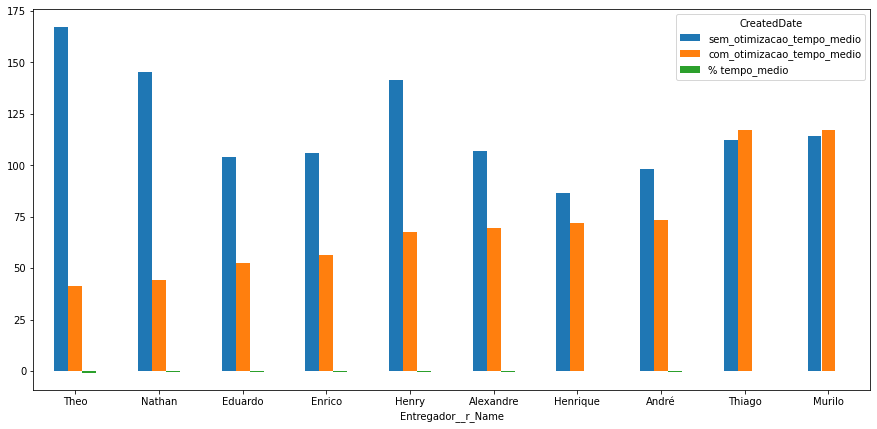

In [184]:
agg.sort_values("com_otimizacao_tempo_medio").plot.bar(rot=0, figsize=(15, 7))

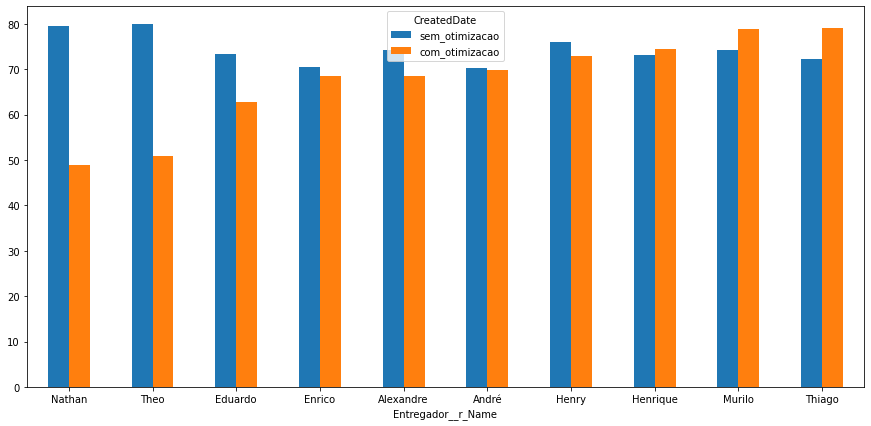

In [185]:
agg = (
    df_result_google
    .pivot(
        index="Entregador__r_Name",
        columns="CreatedDate",
        values="velocity_km_h",
    )
)
agg = agg.reset_index()
agg = agg.set_index("Entregador__r_Name")
agg = agg.rename(
    columns={
        "12/05/2021 21:11":"com_otimizacao",
        "12/05/2021 22:50":"sem_otimizacao",
    }
)
agg = agg[["sem_otimizacao", "com_otimizacao"]]

agg.sort_values("com_otimizacao").plot.bar(rot=0, figsize=(15, 7))